# 📝 Insult Detection with Word2Vec Embeddings

In this notebook, we will build a binary classification pipeline to detect insults in comments using Word2Vec embeddings. We'll apply:
- Logistic Regression
- Random Forest
- XGBoost

## 🚀 Goal
Detect whether a comment contains an insult (1) or not (0).


## 📦 Step 1: Install & Load Packages

In [1]:
!pip install gensim kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import kagglehub


## 📥 Step 2: Load and Inspect the Dataset


In [2]:
train_df = pd.read_csv("/content/jigsaw-toxic-comment-train.csv.zip")
test_df = pd.read_csv("/content/test.csv.zip")

# نمایش نمونه‌ای از داده‌ها
print(train_df.head())
print(test_df.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
   id                                            content lang
0   0  Doctor Who adlı viki başlığına 12. doctor olar...   tr
1   1   Вполне возможно, но я пока не виж

In [3]:
X = train_df['comment_text']
y = train_df['insult']

## 🧹 Step 3: Preprocessing for Word2Vec



In [ ]:
!pip install -q termcolor

In [4]:
# We'll use Gensim's `simple_preprocess` to tokenize and clean the text.


def preprocrss (text):
  return simple_preprocess(text,deacc=True)

X_tokens=X.apply(preprocrss)


In [5]:
from termcolor import colored
print(colored("💬 Original Text:", "cyan", attrs=["bold"]))
print(X.iloc[0])
print()

print(colored("🔹 Tokenized Text:", "green", attrs=["bold"]))
print(X_tokens.iloc[0])

💬 Original Text:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

🔹 Tokenized Text:
['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'weren', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'don', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'retired', 'now']


## 🧠 Step 4: Train Word2Vec Embedding

In [6]:
# We'll train Word2Vec embeddings on the entire corpus.
w2v_model=Word2Vec(
    sentences=X_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    seed=42
)

w2v_model.train(X_tokens,total_examples=len(X_tokens),epochs=10)

(108340092, 140590020)

## 🧬 Step 5: Vectorize Comments using Word2Vec


In [7]:
# Convert each comment to the average of its word vectors
def comment_vector (tokens,model):
  vectors=[model.wv[word] for word in tokens if word in model.wv]
  if len(vectors)>0:
    return np.mean(vectors,axis=0)
  else:
    return np.zeros(model.vector_size)
X_vectors=np.array([comment_vector(tokens,w2v_model) for tokens in X_tokens])


In [8]:
# Convert to final feature and label arrays

y = train_df['insult'].values


print("X shape:", X_vectors.shape)
print("y shape:", y.shape)


X shape: (223549, 100)
y shape: (223549,)


In [9]:
# Train/Test split
X_train,X_test,y_train,y_test=train_test_split(
    X_vectors,y,test_size=0.2,random_state=42
)


## 🤖 Step 6: Train Models

In [10]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



🔍 Logistic Regression Accuracy: 0.9603
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42416
           1       0.70      0.40      0.51      2294

    accuracy                           0.96     44710
   macro avg       0.83      0.69      0.74     44710
weighted avg       0.95      0.96      0.96     44710



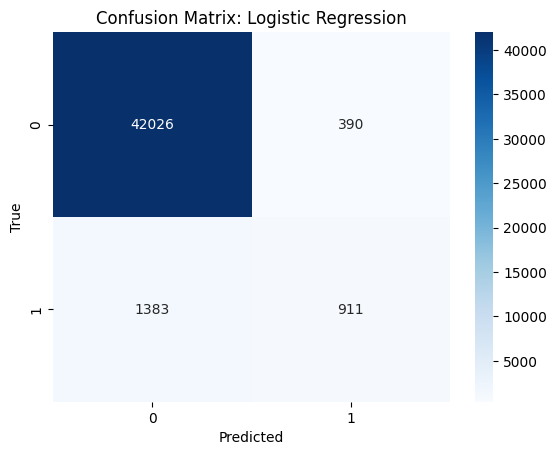

In [11]:
# Logistic Regression

lr = LogisticRegression(max_iter=1000)
evaluate_model(lr, "Logistic Regression")


🔍 Random Forest Accuracy: 0.9648
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42416
           1       0.81      0.41      0.55      2294

    accuracy                           0.96     44710
   macro avg       0.89      0.70      0.76     44710
weighted avg       0.96      0.96      0.96     44710



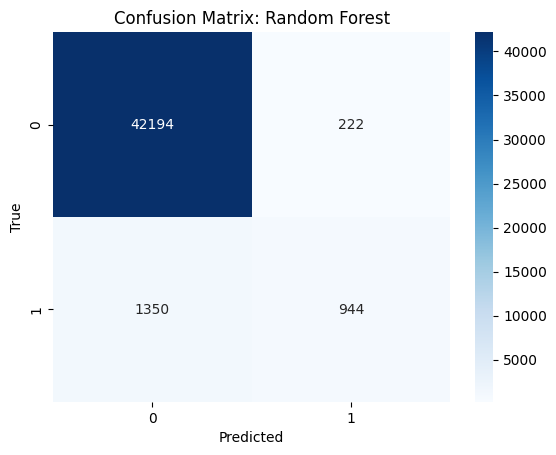

In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf, "Random Forest")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost Accuracy: 0.9673
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     42416
           1       0.74      0.56      0.64      2294

    accuracy                           0.97     44710
   macro avg       0.86      0.78      0.81     44710
weighted avg       0.96      0.97      0.97     44710



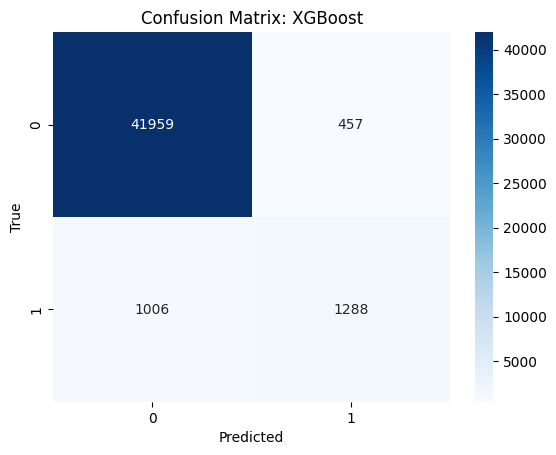

In [ ]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb, "XGBoost")



## 📌 Summary

- You learned how to use Word2Vec embeddings for **insult detection**
- Built a custom vectorizer by averaging word vectors
- Trained Logistic Regression, Random Forest, and XGBoost on the resulting features

### 🔍 Next Steps
- Try pre-trained Word2Vec (e.g. Google News vectors)
- Use TF-IDF weighting for word embeddings
- Try deep learning models (LSTM, BERT, etc.)

🎉 Great job on completing this project!

In [16]:
import gensim.downloader as api

glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def comment_vector_pretrained(tokens,model):
  vectors=[model[word] for word in tokens if word in model]
  if len(vectors)>0:
    return np.mean(vectors,axis=0)
  else:
    return np.zeros(model.vector_size)
X_vectors_pretrained=np.array([comment_vector_pretrained(tokens,glove_vectors) for tokens in X_tokens])

In [ ]:
# Train/Test split
y = train_df['insult']
X_train,X_test,y_train,y_test=train_test_split(
    X_vectors_pretrained,y,test_size=0.2,random_state=42
)



🔍 Logistic Regression Accuracy: 0.9560
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42416
           1       0.66      0.29      0.40      2294

    accuracy                           0.96     44710
   macro avg       0.81      0.64      0.69     44710
weighted avg       0.95      0.96      0.95     44710



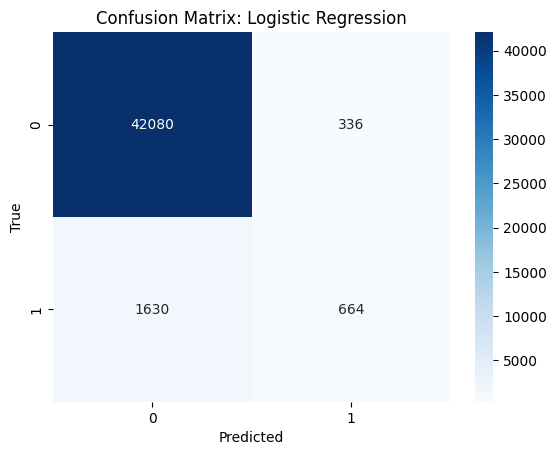

In [ ]:
# Logistic Regression

lr = LogisticRegression(max_iter=1000)
evaluate_model(lr, "Logistic Regression")


🔍 Random Forest Accuracy: 0.9592
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     42416
           1       0.82      0.26      0.39      2294

    accuracy                           0.96     44710
   macro avg       0.89      0.63      0.69     44710
weighted avg       0.95      0.96      0.95     44710



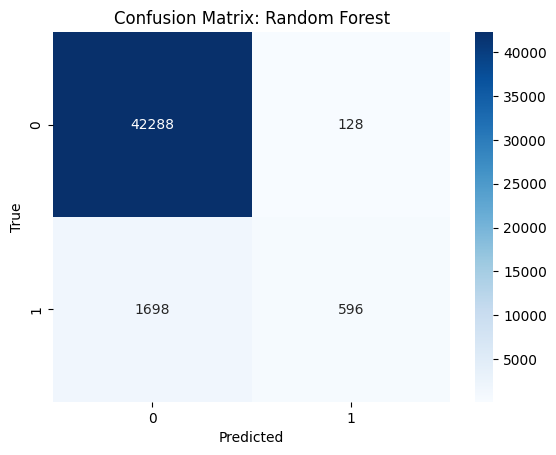

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf, "Random Forest")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:25:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost Accuracy: 0.9629
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42416
           1       0.73      0.44      0.55      2294

    accuracy                           0.96     44710
   macro avg       0.85      0.72      0.77     44710
weighted avg       0.96      0.96      0.96     44710



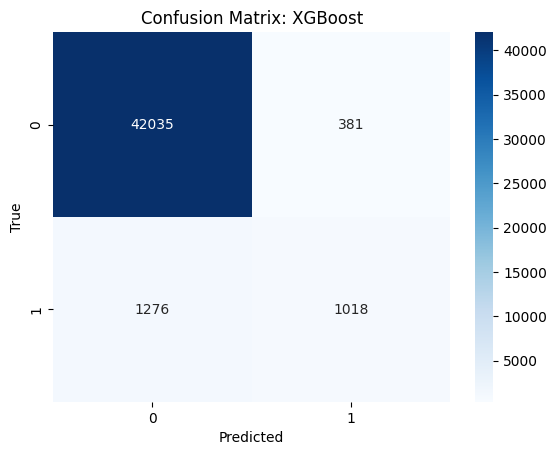

In [ ]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb, "XGBoost")

# Computing TF-IDF for the dataset

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(train_df['comment_text'])
tfidf_feature_names=tfidf.get_feature_names_out()
print(tfidf_feature_names[:10])

['00' '000' '0000' '00000' '000000' '0000000' '00000000' '000000000000'
 '000000000000000' '0000000000000000000000000000']


# Applying TF-IDF to Word2Vec embeddings

In [17]:

tfidf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))


def comment_vector_with_tfidf(tokens, model, tfidf_dict):
    vectors = []
    for word in tokens:
        if word in model and word in tfidf_dict:
            word_tfidf = tfidf_dict[word]
            word_vector = model[word] * word_tfidf
            vectors.append(word_vector)
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


X_vectors_tfidf = np.array([
    comment_vector_with_tfidf(tokens, glove_vectors, tfidf_dict)
    for tokens in X_tokens
])


# Splitting data into train and test sets

In [18]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_vectors_tfidf, y, test_size=0.2, random_state=42)

In [19]:
print(f"Training set size: {X_train_tfidf.shape}")
print(f"Test set size: {X_test_tfidf.shape}")

Training set size: (178839, 100)
Test set size: (44710, 100)


## Training models using TF-IDF weighted embeddings

## Logistic Regression model


🔍 Logistic Regression with TF-IDF + Word2Vec Accuracy: 0.9603
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42416
           1       0.70      0.40      0.51      2294

    accuracy                           0.96     44710
   macro avg       0.83      0.69      0.74     44710
weighted avg       0.95      0.96      0.96     44710



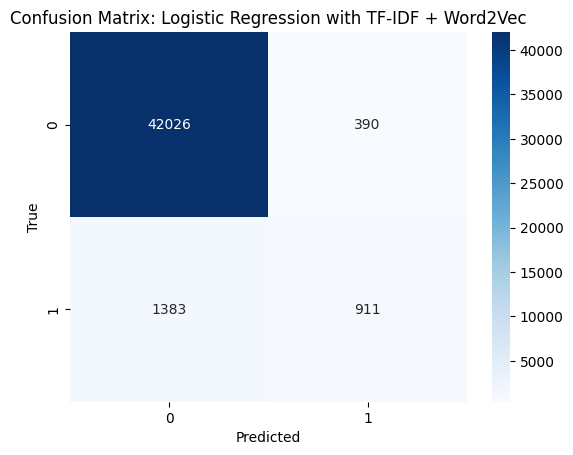

In [20]:
logreg_tfidf = LogisticRegression(max_iter=1000)
evaluate_model(logreg_tfidf, "Logistic Regression with TF-IDF + Word2Vec")


🔍 Random Forest with TF-IDF + Word2Vec Accuracy: 0.9648
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42416
           1       0.81      0.41      0.55      2294

    accuracy                           0.96     44710
   macro avg       0.89      0.70      0.76     44710
weighted avg       0.96      0.96      0.96     44710



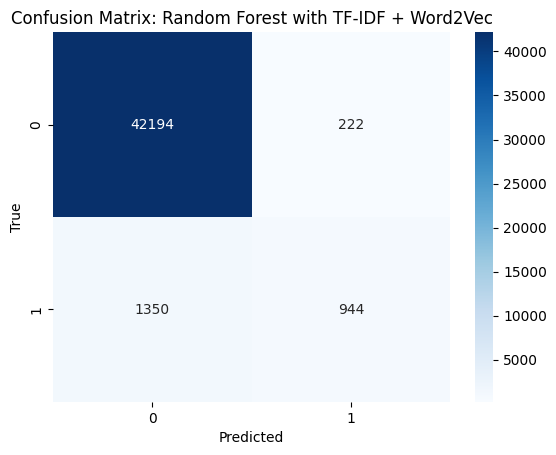

In [21]:
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)

evaluate_model(rf_tfidf, "Random Forest with TF-IDF + Word2Vec")


🔍 XGBoost with TF-IDF + Word2Vec Accuracy: 0.9665
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     42416
           1       0.73      0.54      0.62      2294

    accuracy                           0.97     44710
   macro avg       0.86      0.77      0.80     44710
weighted avg       0.96      0.97      0.96     44710



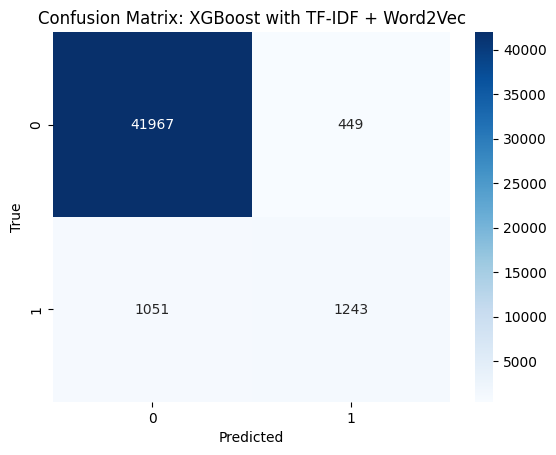

In [22]:
xgb_tfidf = XGBClassifier(random_state=42)


evaluate_model(xgb_tfidf, "XGBoost with TF-IDF + Word2Vec")